**In this notebook we are going to test some data augmentations**

In [1]:
from matplotlib import pyplot as plt 
import keras
import numpy as np
import tensorflow as tf
import math

Load CIFAR-10 dataset

In [2]:
# Load CIFAR-10 dataset 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
print('Training set shape: ', x_train.shape)
print('Test set shape: ', x_test.shape)

Training set shape:  (50000, 32, 32, 3)
Test set shape:  (10000, 32, 32, 3)


In [3]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=32):

    # Randomly crop the image on the scale given
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * crop_size,
        maxval=scale[1] * crop_size,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))

    # Resize the crop back to the original image size
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=32)
    return image

@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)

@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)


@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image, label):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.9)
    image = random_apply(color_drop, image, p=0.3)
    image = random_apply(solarize, image, p=0.3)
    return image, label
  
  

In [4]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = (
    dataset.shuffle(1024, seed=42)
    .map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)


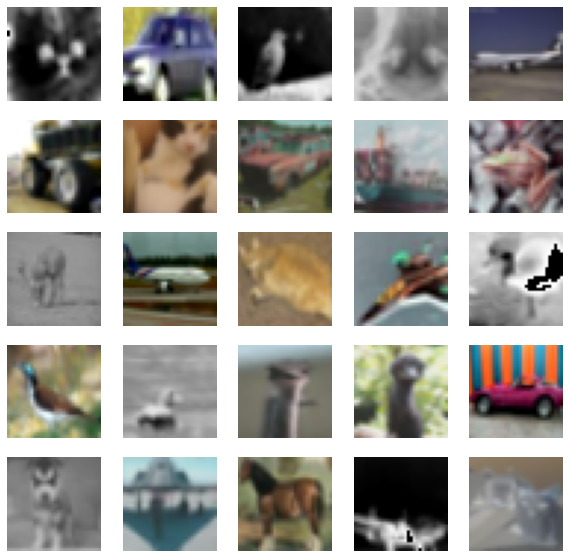

In [5]:
# Visualize augmented images
sample_images = next(iter(dataset))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images[0][n].numpy().astype("int"))
    plt.axis("off")
plt.show()

Define our basic model

In [6]:
def basic_model():
    x_input = tf.keras.Input([32, 32, 3])
    x = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255.0)(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x_input)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(16)(x) # 
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(x_input, x)
    return model

**1 - Let's train with data augmentation**

In [7]:
model = basic_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(dataset,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 24s 14ms/step - loss: 2.4203 - accuracy: 0.2220 - val_loss: 1.8055 - val_accuracy: 0.3290
Epoch 2/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8743 - accuracy: 0.3252 - val_loss: 1.7051 - val_accuracy: 0.4005
Epoch 3/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.7504 - accuracy: 0.3755 - val_loss: 1.6241 - val_accuracy: 0.4144
Epoch 4/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6700 - accuracy: 0.4103 - val_loss: 1.4603 - val_accuracy: 0.4846
Epoch 5/50
1563/1563 [==============================] - 23s 14ms/step - loss: 1.6153 - accuracy: 0.4319 - val_loss: 1.3792 - val_accuracy: 0.5251
Epoch 6/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5692 - accuracy: 0.4485 - val_loss: 1.4089 - val_accuracy: 0.5126
Epoch 7/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5301 - accuracy: 0.4628 - val_loss: 1.3353 -

 **2- Let's train *without* data agumentation now**

In [8]:
dataset2 = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset2 = (
    dataset2.shuffle(1024, seed=42)
    #.map(custom_augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

model2 = basic_model()
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(dataset,
                    epochs=50,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/50
1563/1563 [==============================] - 23s 14ms/step - loss: 2.2442 - accuracy: 0.2322 - val_loss: 1.8229 - val_accuracy: 0.3504
Epoch 2/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8836 - accuracy: 0.3227 - val_loss: 1.8204 - val_accuracy: 0.3290
Epoch 3/50
1563/1563 [==============================] - 23s 14ms/step - loss: 1.7726 - accuracy: 0.3665 - val_loss: 1.9704 - val_accuracy: 0.3413
Epoch 4/50
1563/1563 [==============================] - 23s 14ms/step - loss: 1.7018 - accuracy: 0.3923 - val_loss: 1.7076 - val_accuracy: 0.3949
Epoch 5/50
1563/1563 [==============================] - 23s 14ms/step - loss: 1.6449 - accuracy: 0.4139 - val_loss: 1.4522 - val_accuracy: 0.4893
Epoch 6/50
1563/1563 [==============================] - 23s 14ms/step - loss: 1.5932 - accuracy: 0.4369 - val_loss: 1.4621 - val_accuracy: 0.4825
Epoch 7/50
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5581 - accuracy: 0.4536 - val_loss: 1.4039 -

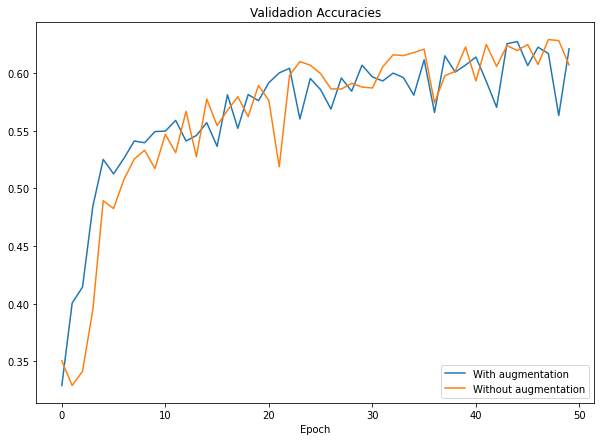

In [9]:
plt.figure(figsize=(10,7))
plt.title('Validation Accuracies')
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('Epoch')
plt.legend(['With augmentation', 'Without augmentation'], loc='lower right')


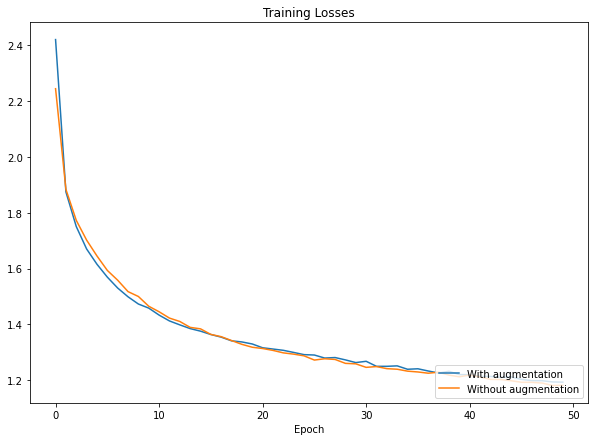

In [10]:
plt.figure(figsize=(10,7))
plt.title('Training Losses')
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.xlabel('Epoch')
plt.legend(['With augmentation', 'Without augmentation'], loc='lower right')